In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio

# POUR LA MORPHO
#from skimage.morphology import watershed
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

#FONCTION viewimage universelle
import IPython

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
#%%
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES: 
colaboratory = False #mettre True si vous utilisez google colab
notebook = True   # mettre True si vous utilisez un notebook local
# les seuls couples possibles sont (False,False)= travailler localement sans notebook
# (False,True): jupyternotebook local
# (True, False): google colab


assert (not (colaboratory and notebook)), "Erreur, choisissez google colab ou notebook local mais pas les deux en meme temps"

if colaboratory: #Si google colab on installe certaines librairies
    !pip install soundfile
    from IPython.display import Audio
    !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    !wget https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
    !tar xvzf donnees_IMA203.tgz
    os.chdir('donnees_IMA203')

if notebook: # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()


Loading BokehJS ...

In [3]:
#%% fonction pour voir une image

def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a /Applications/GIMP.app '
        endphrase=' &' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp -a '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    if titre!='':
        titre='_'+titre+'_'
    nomfichier=tempfile.mktemp('TPIMA'+titre+'.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

#si on est dans un notebook (y compris dans colab), on utilise bokeh pour visualiser

usebokeh = colaboratory or notebook
if usebokeh:
    def normalise_image_pour_bokeh(X,normalise,MINI,MAXI):
        imt=np.copy(X.copy())
        if normalise:
            m=imt.min()
            imt=imt-m
            M=imt.max()
            if M>0:
                imt=imt/M

        else:
            
            imt=(imt-MINI)/(MAXI-MINI)
            imt[imt<0]=0
            imt[imt>1]=1
        imt*=255
      
        sortie=np.empty((*imt.shape,4),dtype=np.uint8)
        for k in range(3):
            sortie[:,:,k]=imt
        sortie[:,:,3]=255
        return sortie
    
    def viewimage(im, normalize=True,titre='',displayfilename=False):
        imin=im.copy().astype(np.float32)
        if normalize:
            imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
        else:
            imin=imin.clip(0,255)/255

        imin=(imin*255).astype(np.uint8)
        filename=tempfile.mktemp(titre+'.png')
        if displayfilename:
            print (filename)
        plt.imsave(filename, imin, cmap='gray')
        IPython.display.display(IPython.display.Image(filename))

In [4]:
#%% fonctions utiles au TP

def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2 = np.fft.fft2
    ifft2 = np.fft.ifft2
    out = np.real(ifft2(fft2(u)*fft2(K)))
    return out    

def degrade_image(im,br): 
    """degrade une image en lui ajoutant du bruit"""
    out=im+br*np.random.randn(*im.shape)
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py): 
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape 
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))
    
    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]
    
    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
    # on n'utilise pas gradx et grady car pour minimiser 
    # la fonctionnelle E2 par descente de gradient nous avons choisi 
    # de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive
     

def resoud_quad_fourier(K,V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """
     
    n = len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx) = K[0].shape
    numer = np.vectorize(complex)(np.zeros((sy,sx)))
    denom = np.vectorize(complex)(np.zeros((sy,sx)))
    fft2 = np.fft.fft2
    ifft2 = np.fft.ifft2
    for k in range(n):
        fV = fft2(V[k])
        fK = fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer += np.conj(fK)*fV
        denom += abs(fK)**2
    return np.real(ifft2(numer/denom))

def minimisation_quadratique(v,lamb):
    """ minimise la fonctionnelle E1 du TP"""
    (sy,sx) = v.shape
    Kx = np.zeros((sy,sx))
    Ky = np.zeros((sy,sx))
    Kx[0,0] = 1
    Kx[0,1] = -1
    Ky[0,0] = 1
    Ky[1,0] = -1
    delta = np.zeros((sy,sx))
    delta[0,0] = 1.0
    s = lamb**0.5
    K = (s*Kx,s*Ky,delta)
    V = (np.zeros((sy,sx)), np.zeros((sy,sx)), v)
    return resoud_quad_fourier(K,V)

def norme_VT(I): 
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        print(k)
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax): 
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman 
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))
    
    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P                

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2 
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))


In [5]:
#%% lire une image

im=imread('lena.tif') #ATTENTION IL FAUT ETRE DANS LE BON REPERTOIRE (utiliser os.chdir())

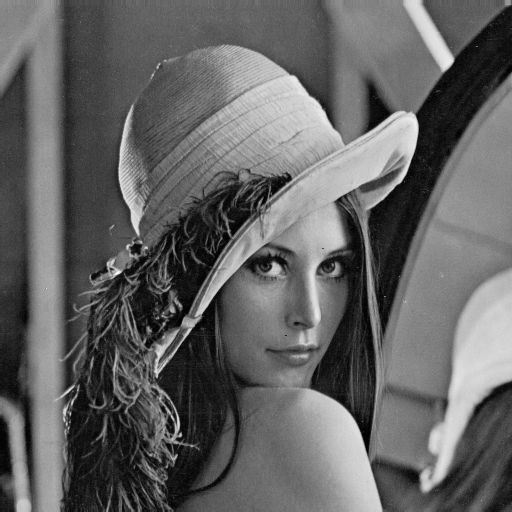

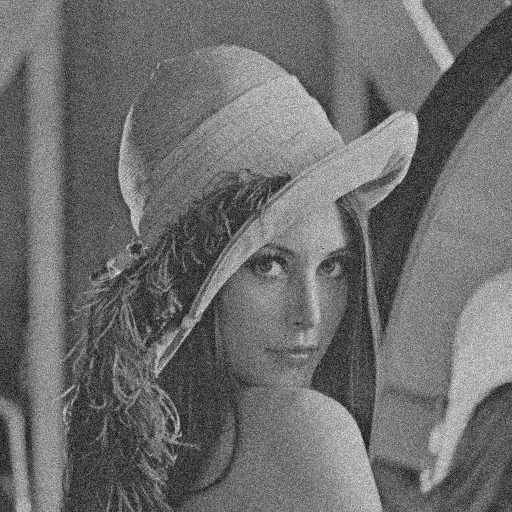

In [6]:
# voir l'image
viewimage(im,titre='ORIGINALE')

#degrader une image
imb=degrade_image(im,25)

# voir l'image bruitée 
viewimage(imb,titre='BRUITEE')

# 1 Débruitage par régularistion quadratique

Le modèle d'observation est

$$ v = u + b $$

où $ v $ est l'image observée (la donnée), $ u $ l'image parfaite et $ b $ le bruit.
On cherche à retrouver $ u $ comme minimiseur de l'énergie

$$ E_1(u) = \lVert u - v \rVert^2 + \lambda \lVert \nabla u \rVert^2 $$

Le premier terme est simplement la norme au carré de la différence entre $ u $ et $ v $. Le second est

$$ \int\int \lVert \nabla u(x,y) \rVert^2 \, dx \, dy $$

C'est-à-dire l'intégrale du carré du gradient de l'image en tout point.


1. Comment utiliser l'otuil ``resoud_quad_fourier`` pour trouver le minimiseur de cette énergie (voir le programme ``minimisation_quadratique``)?

To use the `resoud_quad_fourier` tool to find the minimizer of the energy $ E_1(u) $ as specified in the `minimisation_quadratique` function, the following steps are followed: 

1. **Defining the Filters (Kx, Ky, Delta)**:
   - Three filters are created: two for the partial derivatives (Kx for the x-derivative, and Ky for the y-derivative) and a delta filter to represent the identity.
   - These filters are used to apply the necessary convolution operations in the calculation of the energy $ E_1(u) $.

2. **Preparing the Images (V)**:
   - A set of images `V` corresponding to the filters is created. For the derivative filters (Kx and Ky), the corresponding images to zero are initialized, as these terms don't have a direct component in the observed image `v`.
   - For the delta filter, we use the observed image `v`.

3. **Applying the `resoud_quad_fourier` Function**:
   - The `resoud_quad_fourier` function is called with the filters `K` and images `V`. This function works in the frequency domain to efficiently solve the quadratic minimization problem.
   - In the frequency domain, convolution becomes a simple multiplication, making the computation easier. The function then calculates a ratio between a weighted sum of the products of the Fourier transforms of the images and filters, and a weighted sum of the squares of the Fourier transforms of the filters.

4. **Retrieving the Minimizing Image**:
   - The `resoud_quad_fourier` function returns the image that minimizes the functional $ E_1(u) $ by applying the inverse Fourier transform to get back to the spatial domain.
   - This image is theoretically the "denoised" or restored image, closer to the perfect image `u`.

The `minimisation_quadratique` function sets up the problem by defining the necessary filters and images, and then calls `resoud_quad_fourier` to perform the main computation. This approach leverages the efficiency of the Fourier transform for convolution operations, which is particularly useful in image processing.

2. Décrire le résultar de ce débruitage lorsque $\lambda$ est très grand ou très petit.

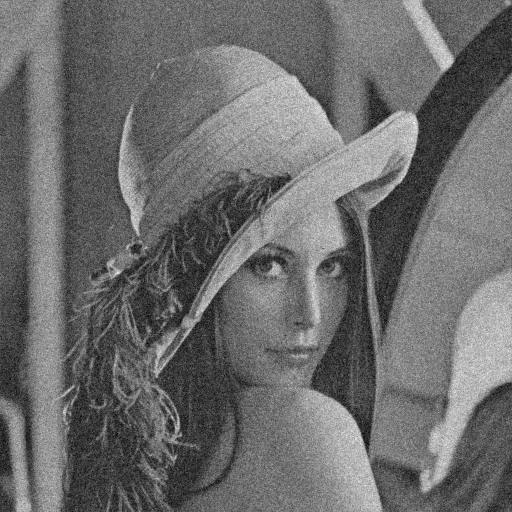

In [7]:
#%% restauration quadratique : exemple
lamb = 0.1
restau = minimisation_quadratique(imb, lamb)
viewimage(restau,titre='RESTQUAD_LAMB='+str(lamb))

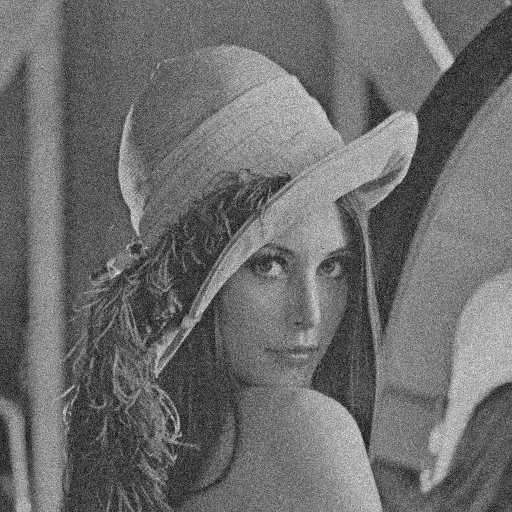

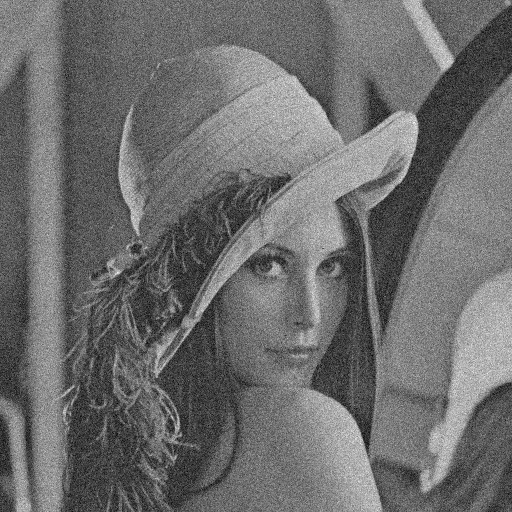

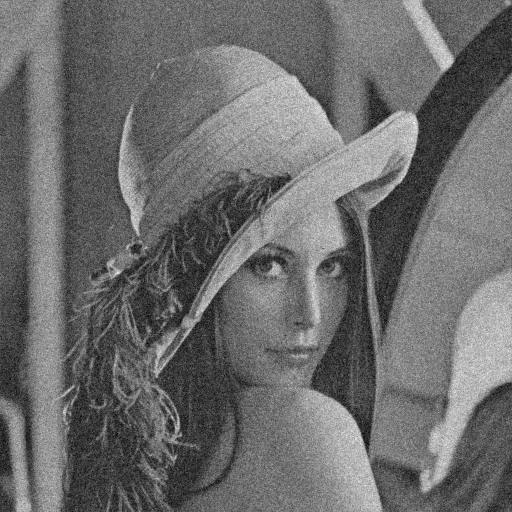

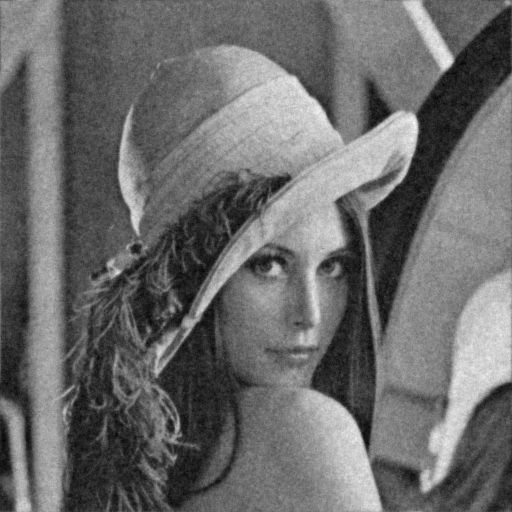

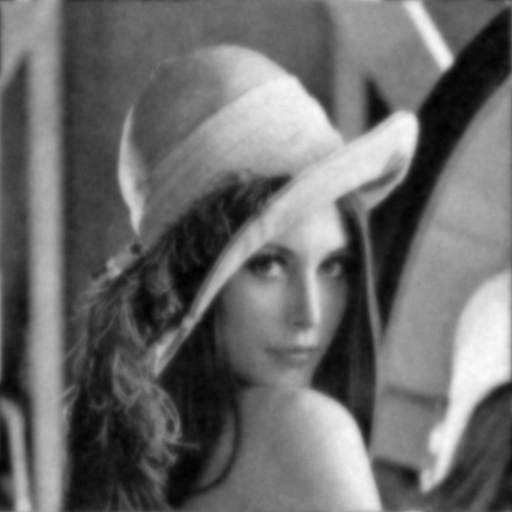

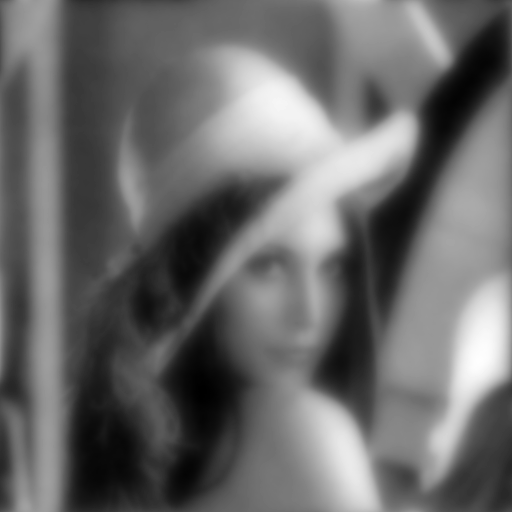

In [8]:
# Using restauration quadratique for lambdas varying from 0.001 up to 100 to see the effects

lambdas = np.logspace(-3,2,6)
restau = [minimisation_quadratique(imb, lamb) for lamb in lambdas]

for i in range(len(lambdas)):
    viewimage(restau[i],titre='RESTQUAD_LAMB='+str(lambdas[i]))


The impact of the parameter $ \lambda $ in the denoising functional $ E_1(u) = \lVert u - v \rVert^2 + \lambda \lVert \nabla u \rVert^2 $ is crucial, and the results vary significantly depending on whether $ \lambda $ is very large or very small.

1. **$ \lambda $ Very Small**:
   - When $ \lambda $ is very small, the regularization term $ \lambda \lVert \nabla u \rVert^2 $ has little influence on the functional.
   - In this case, the minimization will be primarily influenced by the fidelity term $ \lVert u - v \rVert^2 $, which seeks to make the image $ u $ as close as possible to the observed noisy image $ v $.
   - The result will be an image that closely resembles the noisy image, with little reduction in noise. The minimized image is likely to retain much of the noise present in the original image.

2. **$ \lambda $ Very Large**:
   - Conversely, if $ \lambda $ is very large, the regularization term dominates the functional.
   - The term $ \lambda \lVert \nabla u \rVert^2 $ penalizes image variations, thus favoring smoother and more uniform solutions.
   - In this case, the minimization leads to an image that is very smooth, potentially at the expense of losing important details of the original image. The resulting image may appear overly smoothed or blurred, as the priority is given to noise reduction and not to detail preservation.

3. Après avoir ajouté un bruit d’écart type $\sigma = 5$ à l’image de lena, trouver (par dichotimie) le paramètre $\lambda$ pour lequel $||\tilde{u} − v ||^2 ∼ || u − v ||^2$. C’est-à-dire le paramètre pour lequel l’image reconstruite $\tilde{u}$ est à la même distance de l’image dégradée $v$ que ne l'est l'image parfaite. (On respecte la norme du bruit : La norme du bruit est connue même quand on ne connait pas l'image parfaite).

In [9]:
# Dichotomy method to find optimal lambda

def find_optimal_lambda(noisy_image, tolerance=1e-5, max_iter=100, sigma = 5):
    lower_lambda, upper_lambda = 0.01, 10
    target_norm = im.size * sigma

    for i in range(max_iter):
        lambda_test = (lower_lambda + upper_lambda) / 2
        denoised_image = minimisation_quadratique(noisy_image, lambda_test)
        current_norm = norm2(denoised_image - noisy_image)**2

        if np.abs(current_norm - target_norm) < tolerance:
            return lambda_test

        if (current_norm - target_norm) > 0:
            upper_lambda = lambda_test
        else:
            lower_lambda = lambda_test

    return (lower_lambda + upper_lambda) / 2

im5 = degrade_image(im, 5)

optimal_lambda = find_optimal_lambda(im5)

print("Optimal Lambda:", optimal_lambda)
print("Iterations: ", i)

Optimal Lambda: 0.09246080387033434
Iterations:  5


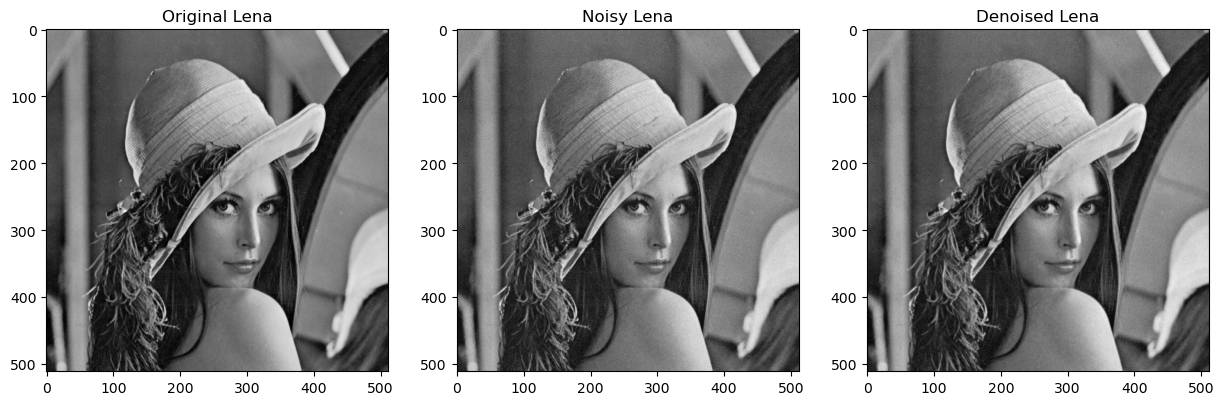

In [10]:
denoised_lena = minimisation_quadratique(im5, optimal_lambda)

# Display images
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(im, cmap='gray'), plt.title('Original Lena')
plt.subplot(132), plt.imshow(im5, cmap='gray'), plt.title('Noisy Lena')
plt.subplot(133), plt.imshow(denoised_lena, cmap='gray'), plt.title('Denoised Lena')
plt.show()

For a single pixel, the variance of the noise would be $ \sigma^2 $. Since the noise is assumed to be independent and identically distributed (i.i.d.) across all pixels, for an image with $ N $ pixels, the expected sum of the squared noise over all pixels (which is the squared norm $ || u - v ||^2 $) would be $ N \times \sigma^2 $.

Then the expected squared norm of the noise is:

$$ || u - v ||^2 = N \times \sigma^2 $$

This is under the assumption that the noise follows a normal distribution and is independent across the image. It is a theoretical expectation because, in practice, the actual noise in each pixel can vary, and the total $ || u - v ||^2 $ for a specific noisy image can deviate from this expectation due to sampling variability. However, this expectation gives us a target value for the dichotomy method to find an optimal $ \lambda $ for the denoising process.

4. Ecrire un algorithme pour trouver le paramètre $\lambda$ tel que $|| \tilde{u} − u ||^2$ soit minimale. (dans le cadre de ce TP on connait l’image parfaite $u$, on général on ne la connait pas). Commentaires ?

In [11]:
# Define a function to find the optimal lambda
def optimal_lambda_u_parfait(u, v, lambda_values):
    best_lambda = None
    min_error = float('inf')
    errors = []  # List to store the errors
    
    for lambda_test in lambda_values:
        tilde_u = minimisation_quadratique(v, lambda_test)
        error = norm2(u - tilde_u)**2
        errors.append(error)  # Append the error to the list
        
        if error < min_error:
            min_error = error
            best_lambda = lambda_test
            
    return best_lambda, min_error, errors  # Return the errors

# Define a range of lambda values to test
lambda_values = np.logspace(-3, 3, 100)  # for example, 100 values between 10^-3 and 10^3

# Find the optimal lambda and get the errors
optimal_lambda, min_error, errors = optimal_lambda_u_parfait(im, imb, lambda_values)

print(f"Optimal Lambda: {optimal_lambda}")
print(f"Minimum Squared Error: {min_error}")

Optimal Lambda: 1.232846739442066
Minimum Squared Error: 28359991.060397055


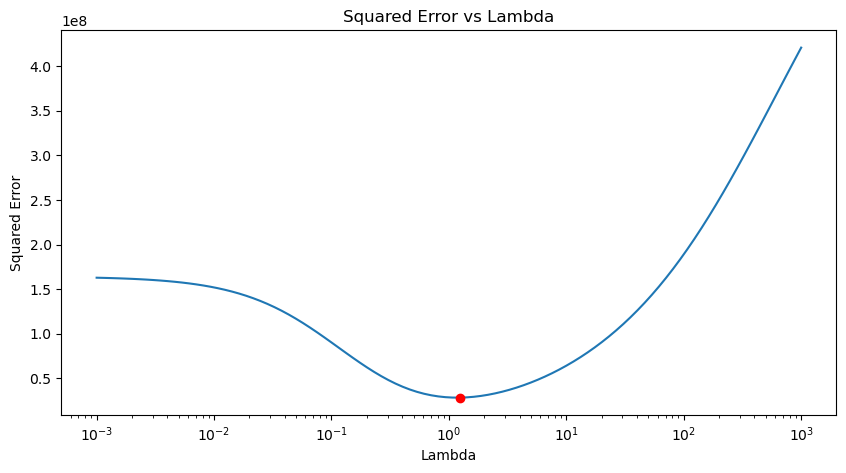

In [12]:
# Plot the errors (x-axis in log scale)
plt.figure(figsize=(10, 5))
plt.semilogx(lambda_values, errors)
plt.plot(optimal_lambda, min_error, 'ro')
plt.xlabel('Lambda')
plt.ylabel('Squared Error')
plt.title('Squared Error vs Lambda')
plt.show()

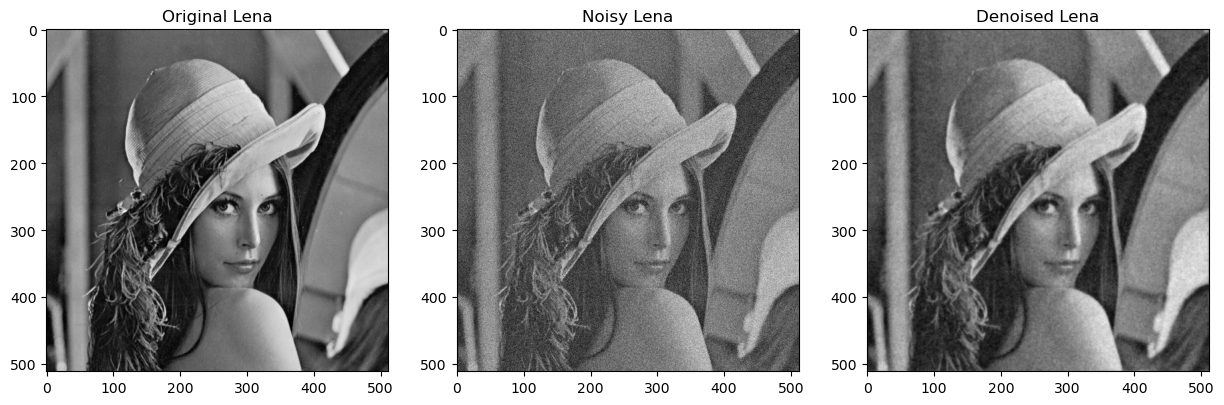

In [13]:
denoised_lena = minimisation_quadratique(imb, optimal_lambda)

# Display images
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(im, cmap='gray'), plt.title('Original Lena')
plt.subplot(132), plt.imshow(imb, cmap='gray'), plt.title('Noisy Lena')
plt.subplot(133), plt.imshow(denoised_lena, cmap='gray'), plt.title('Denoised Lena')
plt.show()

We should not expect to get the same value for $ \lambda $ in questions 3 and 4 because they are optimizing for different outcomes:

1. **Question 3**: We are looking for the value of $ \lambda $ such that the denoised image $ \tilde{u} $ has a squared difference from the noisy image $ v $ that is approximately equal to the squared difference between the perfect image $ u $ and $ v $. This is an indirect measure of denoising quality since we are not comparing the denoised image to the perfect image directly but rather to the same level of noise that was added to the perfect image.

2. **Question 4**: We are directly minimizing the squared difference between the denoised image $ \tilde{u} $ and the perfect image $ u $. This is a direct measure of how close the denoised image is to the perfect image, which is typically the goal of denoising when the perfect image is known.

Because these two questions are optimizing for different things the $ \lambda $ that is optimal for one criterion is not necessarily optimal for the other:

- The $ \lambda $ from Question 3 might result in a denoised image that retains some noise, since it's trying to maintain a level of noise that is expected given the noise norm.
- The $ \lambda $ from Question 4 will likely result in a cleaner image that may not respect the original noise level but is closer to the perfect image.

# 2 Débruitage par variation totale

Dans cette section on utilise la variation totale comme terme de régularisation. Cela donne l'énergie

$$ E_2(u) = \lVert u - v \rVert^2 + \lambda \lVert \nabla u \rVert_1 $$

Le second terme est

$$ \iint \lVert \nabla u(x, y) \rVert \, dx \, dy $$

## 2.1 Descente de gradient

La première idée pour minimiser cette fonctionnelle est d'utiliser une descente de gradient. Nous allons voir que cela peut entraîner des problèmes numériques.

Le gradient de la fonctionnelle $ E_2 $ est donné par

$$ \nabla E_2(u) = 2(u - v) - \lambda \text{div} \left( \frac{\nabla u}{\lVert \nabla u \rVert} \right) $$

Il est calculé par la fonction `gradient_TV`. Utiliser le programme `minimise_TV_gradient` pour différentes valeurs du pas de descente. Atteignez-vous toujours le même minimum d'énergie? (le programme renvoie l'évolution de l'énergie).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\lmcastanedame\AppData\Local\Temp\ipykernel_12412\467772558.py:139: RuntimeWarning: overflow encountered in add
  ng=((gx**2)+(gy**2))**0.5
C:\Users\lmcastanedame\AppData\Local\Temp\ipykernel_12412\467772558.py:143: RuntimeWarning: overflow encountered in square
  return ((x**2).sum())**0.5
C:\Users\lmcastanedame\AppData\Local\Temp\ipykernel_12412\467772558.py:82: RuntimeWarning: overflow encountered in add
  ng=((gx**2)+(gy**2))**0.5+1e-5
C:\Users\lmcastanedame\AppData\Local\Temp\ipykernel_12412\467772558.py:139: RuntimeWarning: overflow encountered in square
  ng=((gx**2)+(gy**2))**0.5
C:\Users\lmcastanedame\AppData\Local\Temp\ipykernel_12412\467772558.py:82: RuntimeWarning: overflow encountered in square
  ng=((gx**2)+(gy**2))**0.5+1e-5


67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


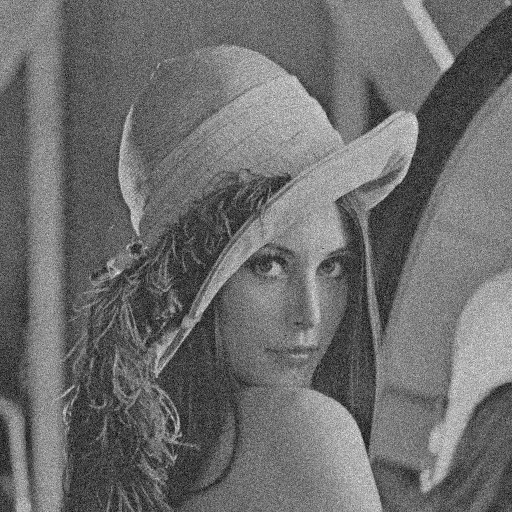

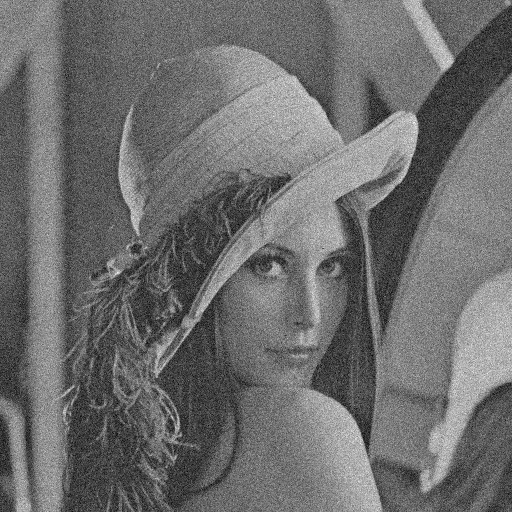

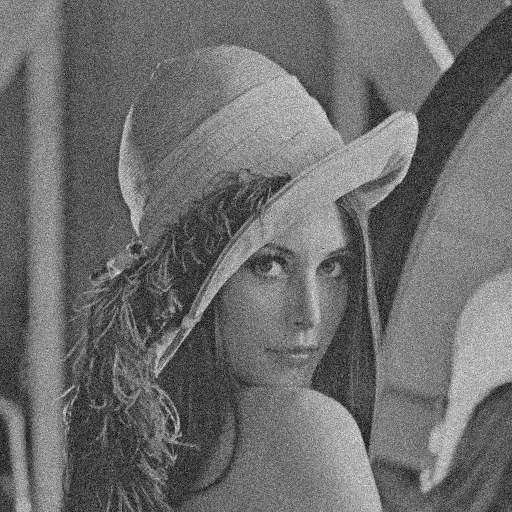

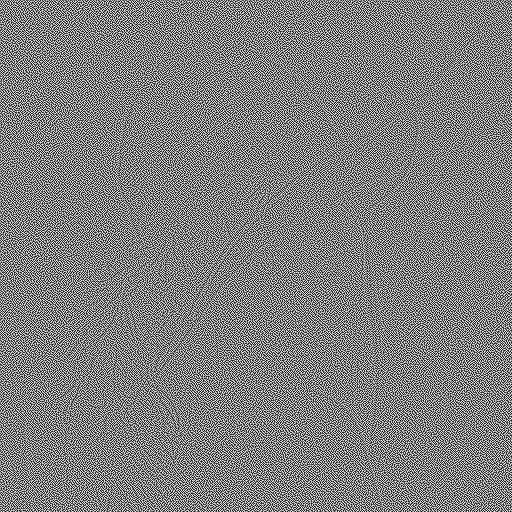

C:\Users\lmcastanedame\AppData\Local\Temp\ipykernel_12412\2314087061.py:71: RuntimeWarning: overflow encountered in cast
  imin=im.copy().astype(np.float32)
C:\Users\lmcastanedame\AppData\Local\Temp\ipykernel_12412\2314087061.py:73: RuntimeWarning: invalid value encountered in subtract
  imin-=imin.min()
C:\Users\lmcastanedame\AppData\Local\Temp\ipykernel_12412\2314087061.py:79: RuntimeWarning: invalid value encountered in cast
  imin=(imin*255).astype(np.uint8)


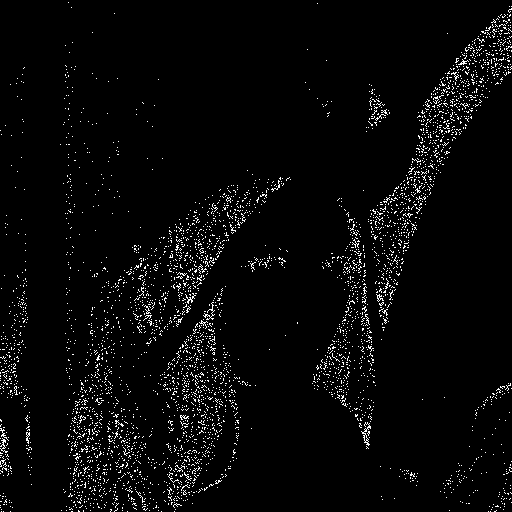

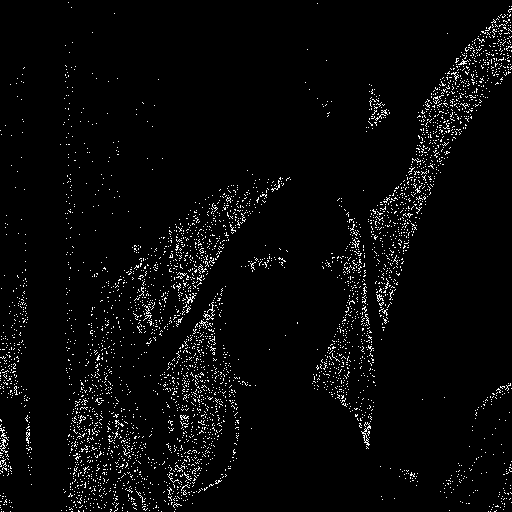

In [14]:
# Using minimise_TV_gradient for steps varying from 0.001 up to 100 to see the effects

steps = np.logspace(-3,2,6)
restau = [minimise_TV_gradient(imb, lamb, step, 100)[0] for step in steps]

for i in range(len(steps)):
    viewimage(restau[i],titre='RESTQUAD_LAMB='+str(steps[i]))

The gradient descent algorithm is sensitive to the choice of step size. This determines how much the current estimate of the solution $ u $ is adjusted at each iteration of the algorithm. There are several reasons why different step sizes might not converge to the same minimum energy:

1. **Convergence Rate**: A step size that is too large might cause the algorithm to overshoot the minimum, leading to divergence or oscillation around the minimum. Conversely, a step size that is too small might result in a very slow convergence, and the algorithm might not reach the minimum within the given number of steps.

2. **Numerical Stability**: Gradient descent relies on numerical methods that can accumulate errors, especially if the step size is not well-chosen. Large steps might result in numerical instability, while very small steps could lead to precision issues due to the limited floating-point representation in computers.

3. **Local Minima and Saddle Points**: Depending on the complexity of the energy landscape, there may be multiple local minima or saddle points. A different step size could lead the descent to converge to different local minima.

4. **Gradient Magnitude**: The gradient of the energy function, $ \nabla E_2(u) $, provides the direction of the steepest increase, so the negative gradient points towards the steepest decrease. If the gradient is very steep, a large step might be problematic, and if it's shallow, a small step might not make sufficient progress.

## 2.2 Projection Chambolle

Le programme ``vartotale_Chambolle`` applique la méthode de Chambolle (expliquée dans le polycopié) au même problème posé par $E_2$. Utilisez ce programme et que constatez-vous quant à la vitesse de cette algorithme et sa précision (minimisation effective de $E_2$) par rapport à la descente de gradient. Dans la suite vous n’utiliserez plus que cette technique pour minimiser la fonctionnelle $E_2$.

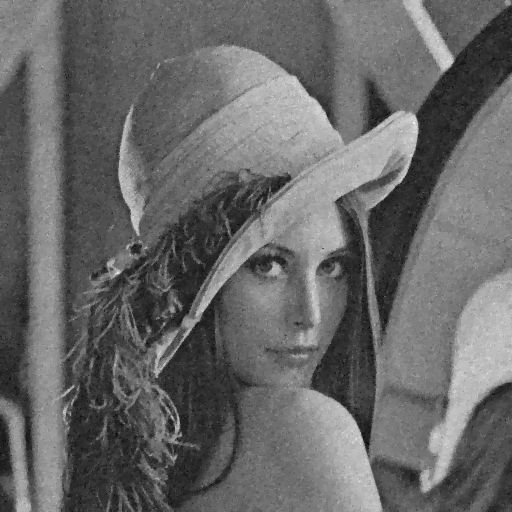

In [15]:
# Utilisez le programme vartotale_Chambolle pour restaurer l'image imb

restau = vartotale_Chambolle(imb, 25)
viewimage(restau,titre='RESTVARTOTALE')


1. **Speed (Convergence Rate)**:
   - Chambolle's algorithm is typically faster than standard gradient descent due to a more stable convergence pattern.
   - Gradient descent can be slow, particularly near saddle points or flat regions of the energy landscape.
   - Chambolle's method is designed to take into account the structure of the TV norm, allowing for larger step sizes without overshooting, which results in faster convergence.

2. **Precision (Effective Minimization)**:
   - Chambolle's algorithm can often achieve a more accurate minimization of $ E_2 $ because it directly addresses the non-differentiability of the TV norm by working on its dual problem.
   - Standard gradient descent may have trouble with the non-smooth nature of the TV norm, which can lead to less accurate results, especially if not carefully tuned.
   - The algorithm's iterative projection step ensures that the solution stays within the feasible set of the TV norm, which promotes more precise minimization.

# 3 Comparaison

Après avoir fixé une image bruitée par un bruit de 25, trouver pour chacune des deux méthodes (TV et quadratique) le meilleur paramètre $\lambda$ et comparez qualitativement le résultat obtenu par les deux méthodes pour le débruitage.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# COMPARISON of methods

errq = []
errvt = []
vk = np.logspace(-3, 3, 30)
for k in vk:
    print(k)
    restq = minimisation_quadratique(imb, k)
    errq.append(norm2(restq - im))
    
    restva = vartotale_Chambolle(imb, k)
    errvt.append(norm2(restva - im))

0.001
0.0016102620275609393
0.002592943797404667
0.0041753189365604
0.006723357536499335
0.010826367338740546
0.017433288221999882
0.02807216203941177
0.04520353656360243
0.0727895384398315
0.11721022975334805
0.18873918221350977
0.3039195382313198
0.4893900918477494
0.7880462815669912
1.2689610031679222
2.0433597178569416
3.2903445623126677
5.298316906283707
8.531678524172806
13.738237958832638
22.122162910704503
35.622478902624444
57.361525104486816
92.36708571873865
148.73521072935117
239.5026619987486
385.6620421163472
621.0169418915616
1000.0


In [28]:
min_errq_index = np.argmin(errq)
min_errq = errq[min_errq_index]
corresponding_vk_q = vk[min_errq_index]

min_errvt_index = np.argmin(errvt)
min_errvt = errvt[min_errvt_index]
corresponding_vk_vt = vk[min_errvt_index]

print(f"Optimal Lambda Quadratique: {corresponding_vk_q}")
print(f"Optimal Lambda TV: {corresponding_vk_vt}")


Optimal Lambda Quadratique: 1.2689610031679222
Optimal Lambda TV: 35.622478902624444


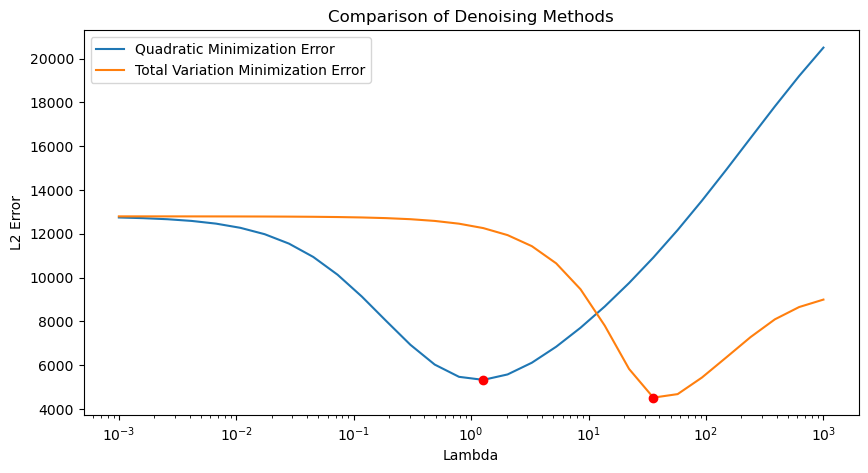

In [27]:
# Plotting the errors
plt.figure(figsize=(10, 5))
plt.semilogx(vk, errq, label='Quadratic Minimization Error')
plt.semilogx(vk, errvt, label='Total Variation Minimization Error')
plt.plot(corresponding_vk_q, min_errq, 'ro')
plt.plot(corresponding_vk_vt, min_errvt, 'ro')
plt.xlabel('Lambda')
plt.ylabel('L2 Error')
plt.legend()
plt.title('Comparison of Denoising Methods')
plt.show()


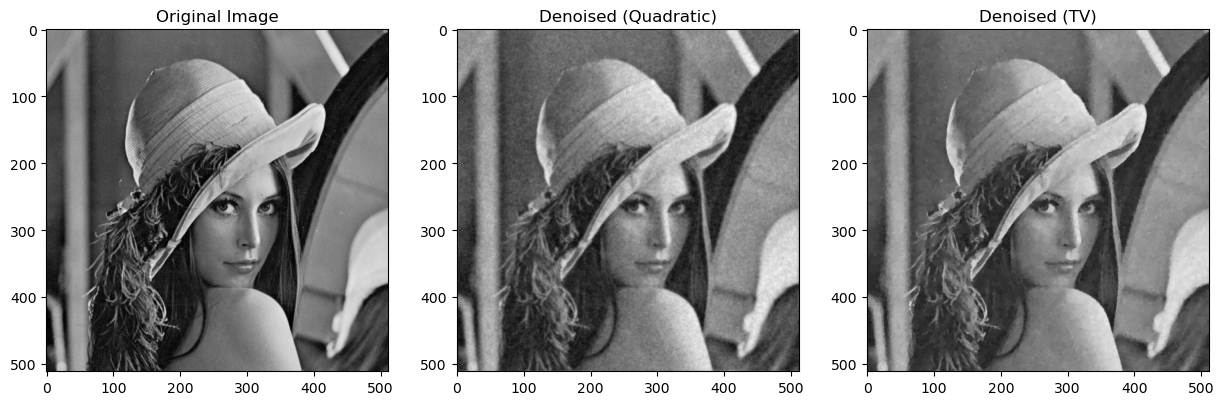

In [29]:
# Denoise using optimal lambda for quadratic method
denoised_quadratic = minimisation_quadratique(imb, corresponding_vk_q)

# Denoise using optimal lambda for TV method
denoised_tv = vartotale_Chambolle(imb, corresponding_vk_vt)

# Display images
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(im, cmap='gray'), plt.title('Original Image')
plt.subplot(132), plt.imshow(denoised_quadratic, cmap='gray'), plt.title('Denoised (Quadratic)')
plt.subplot(133), plt.imshow(denoised_tv, cmap='gray'), plt.title('Denoised (TV)')
plt.show()

In [17]:
#%%
u1,en1=minimise_TV_gradient(imb, 40, 1, 20)
u05,en05=minimise_TV_gradient(imb, 40, 0.5, 20)
u01,en01=minimise_TV_gradient(imb, 40, 0.1, 20)
#u05inf,en05inf=minimise_TV_gradient(imb, 10, 0.5, 200)

0
1
2


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


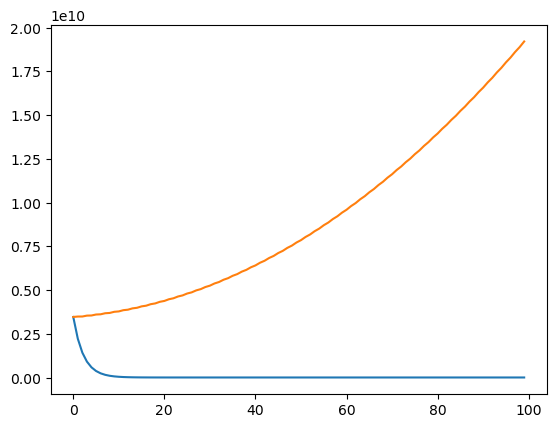

In [18]:
#%%
myim=imread('lena.tif')
imb=degrade_image(myim,25)
(u,energ)=minimise_TV_gradient(imb,1,0.1,100)   # pas = 0.1
(u,energ2)=minimise_TV_gradient(imb,1,1,100)       # pas = 1
plt.plot(energ)
plt.plot(energ2)